<a href="https://colab.research.google.com/github/abdulrahman-hassanin/BERT_Spam_Detection/blob/main/BERT_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Spam Detection with BERT
This project aims to fine-tune BERT model to detect spam SMS using [SMS Spam Collection](https://www.kaggle.com/uciml/sms-spam-collection-dataset). The dataset consist of 5,574 English SMS which tagged accroding ham or spam.

In [ ]:
from google.colab import files
files.upload() #upload kaggle.json

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.jso

In [ ]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset

In [ ]:
!unzip /content/sms-spam-collection-dataset.zip

#Import Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.shape

(5572, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [ ]:
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
class_dict = {
    'ham': 0,
    'spam':1
}

df['target'] = df['target'].map(class_dict)
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['text'][2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

# EDA

In [ ]:
# duplicated values
df.duplicated().sum()

403

In [ ]:
# drop duplicated values
df=df.drop_duplicates(keep='first')
df.duplicated().sum()

0

In [ ]:
df['target'].value_counts(normalize=True)

0    0.87367
1    0.12633
Name: target, dtype: float64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


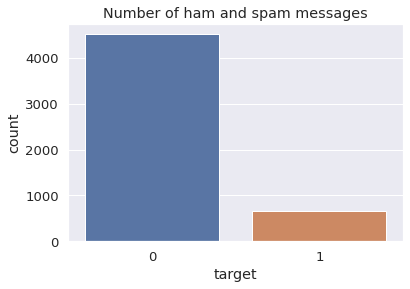

In [ ]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(df.target).set_title("Number of ham and spam messages")
plt.show()

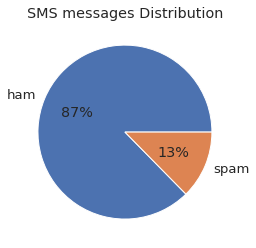

In [ ]:
sms = pd.value_counts(df["target"], sort=True)
sms.plot(kind="pie", labels=["ham", "spam"], autopct="%1.0f%%")

plt.title("SMS messages Distribution")
plt.ylabel("")
plt.show()

In [ ]:
df['length'] = df.text.apply(len)
df.head()

,target,text,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


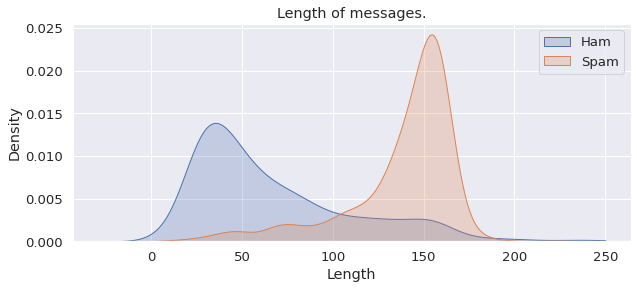

In [ ]:
_, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(df.loc[df.target == 0, "length"], shade=True, label="Ham", clip=(-50, 250),)
sns.kdeplot(df.loc[df.target == 1, "length"], shade=True, label="Spam")
ax.set(
    xlabel="Length",
    ylabel="Density",
    title="Length of messages.",
)
ax.legend(loc="upper right")
plt.show()

# Text Pre-processing

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = stopwords.words('english')
print(stop_words[::10])

porter = PorterStemmer()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [ ]:
def clean_text(words):
    """The function to clean text"""
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()                   
    return " ".join(text)

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

In [ ]:
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].apply(remove_stopwords)
df['text'] = df['text'].apply(stemmer)

df.head()

,target,text,length
0,0,go jurong point crazi avail bugi n great world...,111
1,0,ok lar joke wif u oni,29
2,1,free entri wkli comp win fa cup final tkt st m...,155
3,0,u dun say earli hor u c alreadi say,49
4,0,nah think goe usf live around though,61


In [ ]:
print(df['text'].apply(lambda x: len(x.split(' '))).sum())

45463


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],df['target'], 
                                                    stratify=df['target'], 
                                                    test_size=0.3)

# BERT
Fine-tune BERT and use it as an encoder.

In [ ]:
!pip install tensorflow-text

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as tf_text
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
weights = compute_class_weight(class_weight='balanced', 
                                 classes=np.unique(y_train), 
                                 y=y_train)

class_weight = {0: weights[0], 1: weights[1]}


print(class_weight)

{0: 0.5722872508699779, 1: 3.9584245076586435}


In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=25,
    verbose=1,
    validation_data=(X_test, y_test),
    class_weight=class_weight
)

Epoch 1/25
114/114 [==============================] - 56s 467ms/step - loss: 0.3036 - accuracy: 0.8922 - precision: 0.5455 - recall: 0.8796 - val_loss: 0.2389 - val_accuracy: 0.9201 - val_precision: 0.6364 - val_recall: 0.8571
Epoch 2/25
114/114 [==============================] - 58s 508ms/step - loss: 0.2911 - accuracy: 0.8986 - precision: 0.5632 - recall: 0.8775 - val_loss: 0.2978 - val_accuracy: 0.8878 - val_precision: 0.5337 - val_recall: 0.8878
Epoch 3/25
114/114 [==============================] - 58s 511ms/step - loss: 0.2907 - accuracy: 0.8853 - precision: 0.5277 - recall: 0.8753 - val_loss: 0.3567 - val_accuracy: 0.8627 - val_precision: 0.4776 - val_recall: 0.9235
Epoch 4/25
114/114 [==============================] - 59s 515ms/step - loss: 0.2858 - accuracy: 0.8944 - precision: 0.5505 - recall: 0.8950 - val_loss: 0.2405 - val_accuracy: 0.9142 - val_precision: 0.6129 - val_recall: 0.8724
Epoch 5/25
114/114 [==============================] - 59s 519ms/step - loss: 0.2831 - accura

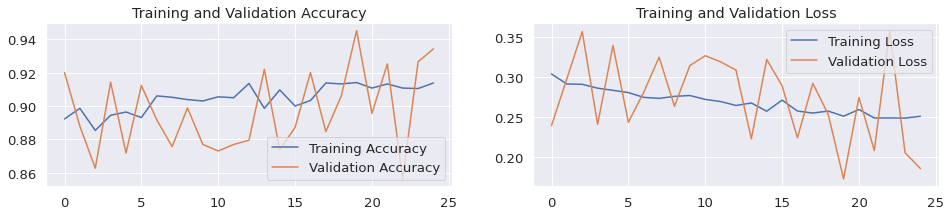

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
# plt.savefig('graph4_97_final.jpg')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

49/49 [==============================] - 16s 333ms/step - loss: 0.1850 - accuracy: 0.9342 - precision: 0.7009 - recall: 0.8367


[0.1850157529115677,
 0.9342359900474548,
 0.7008547186851501,
 0.8367347121238708]

# Model Prediction

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

49/49 [==============================] - 18s 345ms/step


In [ ]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[1285,   70],
       [  32,  164]])

Text(63.5, 0.5, 'Truth')

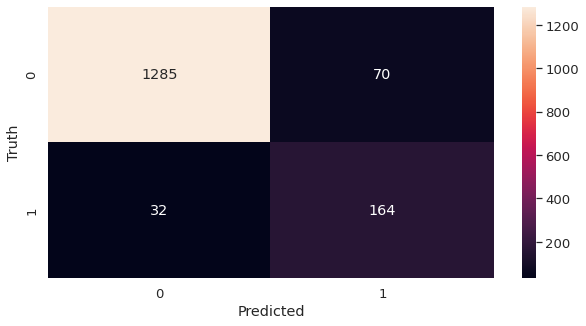

In [ ]:
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1355
           1       0.70      0.84      0.76       196

    accuracy                           0.93      1551
   macro avg       0.84      0.89      0.86      1551
weighted avg       0.94      0.93      0.94      1551

